# Import CEseek

In [121]:
from CEseek_class import *
import os, pickle, logging, numpy as np, pandas as pd, multiprocessing as mp, glob, random, re
from tqdm import tqdm
from collections import OrderedDict
from pathlib import Path
logging.basicConfig(filename='ceseek_cicero.log', level=logging.INFO, format='%(asctime)s %(message)s', datefmt='%H:%M:%S')
wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/'
out_path = os.path.join(wd, 'out_data', 'ce_seek_1')
os.makedirs(f"{out_path}/figures", exist_ok=True)
os.makedirs(f"{out_path}/out_files/txt_files_for_cicero", exist_ok=True) # will make outfiles too if they don't exist
os.makedirs(f"{out_path}/scripts", exist_ok=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

### Creating TF of interest files and reading tf combination of interest

In [2]:
from gimmemotifs.config import DIRECT_NAME, INDIRECT_NAME
from gimmemotifs.motif import Motif, default_motifs
import sys, re
from collections import defaultdict, OrderedDict


class MotifAnalysis():
    def __init__(self):
        self.motifs=set()
        self.dict_motif2TFs = defaultdict(lambda: OrderedDict({
            "db_type": None,
            "factors_trancription": None,
            "ppm": None,
            "max_score": None,
        }))

    def _formatting_TFs(self, species, factor):
        if species in ["Mouse", "Rat"]:
            factor_formatted = [tf.capitalize() for tf in factor]
        elif species in ["Human", "S.cerevisiae", "Arabidopsis", "Axolotl"]:
            factor_formatted = [tf.upper() for tf in factor]
        elif species in ["Zebrafish", "Xenopus"]:
            factor_formatted = [tf.lower() for tf in factor]
        elif species in ["Drosophila", "C.elegans"]:
            pass
        return factor_formatted

    def create_motif2TFs(self, species = "Human", TF_evidence_level='direct_and_indirect', formatting=True):
        assert species in ["Human", "Mouse", "Rat", "S.cerevisiae", "Arabidopsis", "Axolotl", "Zebrafish", "Xenopus", "Drosophila", "C.elegans"], \
                "species should be one of the following: Human, Mouse, Rat, S.cerevisiae, Arabidopsis, Axolotl, Zebrafish, Xenopus, Drosophila, C.elegans"
        
        for motif in self.motifs:
            if motif.db == "hocomoco":
                factor = motif.id.split("_")[0]
            elif motif.db == "meme":
                factor = motif.id.split("|")[1]
            elif motif.db == "jaspar":
                factor = motif.id.split("|")[1]
            elif motif.db == "gimmemotif":
                if TF_evidence_level == "direct_and_indirect":
                    factor_kind = [DIRECT_NAME, INDIRECT_NAME]
                elif TF_evidence_level == "direct":
                    factor_kind = [DIRECT_NAME]
                factor = []
                for j in factor_kind:
                    factor += motif.factors[j]
            else:
                factor = None

            self.dict_motif2TFs[motif.id]["db_type"] = motif.db
            if isinstance(factor, str):
                factor = [factor]
            if formatting:
                factor = self._formatting_TFs(species, factor)
            
            self.dict_motif2TFs[motif.id]["factors_trancription"] = factor
            self.dict_motif2TFs[motif.id]["ppm"] = motif.ppm
            self.dict_motif2TFs[motif.id]["max_score"] = motif.max_score
        return self.dict_motif2TFs
    
    def read_pfm_motifs(self, pfm_file_path, db='pfm', return_motifs=False):
        with open(pfm_file_path) as handle:
            p = re.compile(
                r"(\d+(\.\d+)?(e-\d+)?)\s+(\d+(\.\d+)?(e-\d+)?)\s+(\d+(\.\d+)?(e-\d+)?)\s+(\d+(\.\d+)?(e-\d+)?)"  # noqa: E501
            )
            motifs = []
            pfm = []
            motif_id = ""
            seen_id = {}

            for n, line in enumerate(handle.readlines()):
                if line.startswith("#") or line.strip() == "":
                    continue
                if line.startswith(">"):
                    if pfm:
                        motifs.append(Motif(pfm))
                        motifs[-1].id = motif_id
                        motifs[-1].db = db
                        pfm = []
                    motif_id = line.strip()[1:]
                    seen_id[motif_id] = seen_id.get(motif_id, 0) + 1
                    if seen_id.get(motif_id, 0) > 1:
                        msg = "WARNING: multiple motifs with same id: {}\n".format(motif_id)
                        sys.stderr.write(msg)
                        motif_id += "_{}".format(seen_id[motif_id] - 1)

                else:
                    m = p.search(line)
                    if m:
                        fractions = [float(m.group(x)) for x in (1, 4, 7, 10)]
                        pfm.append(fractions)
                    else:
                        msg = "WARNING: can't parse line {}, ignoring:\n{}".format(n + 1, line)
                        sys.stderr.write(msg)

            if len(pfm) > 0:
                motifs.append(Motif(pfm))
                motifs[-1].id = motif_id
                motifs[-1].db = db
        self.motifs = self.motifs.union(set(motifs))
        if return_motifs:
            return motifs
        else: 
            return None

    def read_memev4_motifs(self, meme_file_path, db='meme', return_motifs=False):
        with open(meme_file_path) as handle:
            motifs = []
            line = handle.readline()
            while line:
                while line and not line.startswith("MOTIF"):
                    line = handle.readline()

                if line:
                    mid = " ".join(line.strip().split(" ")[1:])
                    freqs = []
                    while not line.startswith("letter"):
                        line = handle.readline()
                    while line:
                        line = handle.readline()
                        if (not line.strip()) or (line.startswith("URL")):
                            break

                        row = [float(x) for x in re.split(r"\s", line.strip()) if x != '']
                        freqs.append(row)

                    motif = Motif(freqs)
                    motif.id = mid.replace(" ", "|")
                    motif.db = db
                    motifs.append(motif)
        self.motifs = self.motifs.union(set(motifs))
        if return_motifs:
            return motifs
        else: 
            return None

    def _get_default_motifs(self, return_motifs=False):
        motifs = default_motifs()
        self.motifs = self.motifs.union(set(motifs))
        for motif in motifs:
            motif.db = "gimmemotif"
        if return_motifs:
            return motifs
        else: 
            return None


In [3]:
ma= MotifAnalysis()
jaspar_file_path = f"{wd}/out_data/out_other_methods/motifs/jaspar/JASPAR2024_CORE_non-redundant_pfms_meme.txt"
pfm_file_path = f"{wd}/out_data/out_other_methods/motifs/hocomoco/HOCOMOCOv11_core_pcms_HUMAN_mono.txt"
lin_lab_path = f"{wd}/out_data/out_other_methods/motifs/CRC_lin_lab/VertebratePWMs.txt"

ma.read_memev4_motifs(jaspar_file_path, db='jaspar')
ma.read_pfm_motifs(pfm_file_path,db='hocomoco')
ma.read_memev4_motifs(lin_lab_path, db='meme')
ma._get_default_motifs()
dict_motif2TFs = ma.create_motif2TFs(species = "Human")

In [5]:
import pandas as pd, os
def save_ppm_with_header(row, save_path):
    os.makedirs(save_path, exist_ok=True)  # Ensure the directory exists
    filename = os.path.join(save_path, f"{row['factors_trancription']}.txt")
    header = f">{row['motif_id']}_{row['db_type']}\t{row['factors_trancription']}\t{row['motif_score']}\n"

    # Save with header
    with open(filename, "w") as f:
        f.write(header)  # Write the header
        np.savetxt(f, row["ppm"], delimiter="\t", fmt="%.6f")  # Write the matrix

# Apply function to all rows
def save_individual_motif_files(dict_motif2TFs, save_path, pct_cutoff = 0.8, db_preferred_order = ["jaspar", "hocomoco", "gimmemotif", "meme"]):
    keywords_to_remove = ["DBD", "primary"]
    pattern = '|'.join(keywords_to_remove)
    df = pd.DataFrame.from_dict(dict_motif2TFs, orient='index').explode('factors_trancription').reset_index(drop=False).rename(columns={"index": "motif_id"})
    df["rank"] = df["db_type"].apply(lambda x: db_preferred_order.index(x) if x in db_preferred_order else len(db_preferred_order))
    df["motif_score"] = df["max_score"] * pct_cutoff
    df["factors_trancription"] = df["factors_trancription"].str.split(".").str.get(0).str.replace("/", "").str.replace(pattern,"",regex=True)  # Remove any "_word" patterns
    df_sorted = df.sort_values(by=["factors_trancription","rank", "max_score"], ascending=True)
    df_best = df_sorted.groupby("factors_trancription").first().reset_index()
    df_best = df_best.drop(columns=["rank"])
    df_best.apply(lambda row: save_ppm_with_header(row, save_path), axis=1)
    return df_best

save_path = f"{out_path}/out_files/motifs"
df_best = save_individual_motif_files(dict_motif2TFs, save_path)

In [228]:
import random, ast
random.seed(42)
class CombCtrl():
    def __init__(self, cc_dict, out_path):
        self.cc_dict = cc_dict
        self.comb_of_interest = {"actual": set(), "control": set(), "network": set()}
        self.tf_of_interest = set()
        self.out_path = out_path
        motif_files = glob.glob(f"{self.out_path}/out_files/motifs/*.txt")
        motif_TFs = [os.path.basename(file).rsplit(".txt", 1)[0] for file in motif_files]
        self.tf_with_motif = set(motif_TFs)
    
    def extract_tf_enrichment(self, mode, cluster_pair,cc_dict):
        if mode == "single":
            key = '1'
            condition = [(1,)]
        elif mode == "double":
            key = '2'
            condition = [(1,1), (1,0), (0,1)]
        else:
            raise ValueError("mode should be either 'single' or 'double'")
        
        enrichment_df = pd.DataFrame(cc_dict[cluster_pair][key], columns=['TF', 'Condition', 'ES', 'Genes'])
        enrichment_df[['Score', 'p_value']] = pd.DataFrame(enrichment_df['ES'].tolist(), index=enrichment_df.index)
        enrichment_df[['common', 'dwnstrm']] = pd.DataFrame(enrichment_df['Genes'].tolist(), index=enrichment_df.index)
        enrichment_df = enrichment_df.drop(columns=['ES', 'Genes'])
        filter_enrichment_df = (enrichment_df['p_value']<1) \
                                & (enrichment_df['dwnstrm'].apply(len)>1) & (enrichment_df['common'].apply(len)>1) \
                                & (enrichment_df['Score']>0) \
                                & (enrichment_df['Condition'].isin(condition))
        enrichment_df = enrichment_df[filter_enrichment_df].sort_values(by='Score', ascending=False)
        return enrichment_df

    def single_tf_enrichment(self, cluster_pair,cc_dict, write=True):
        extracted_enrichment_df = self.extract_tf_enrichment("single", cluster_pair, cc_dict)
        if write:
            extracted_enrichment_df.to_csv(f"{self.out_path}/out_files/SLIDE_LF_enriched_single_TFs_{cluster_pair}.csv", index=False)
        return extracted_enrichment_df
    
    def double_tf_enrichment(self, cluster_pair,cc_dict, write=True):
        extracted_enrichment_df = self.extract_tf_enrichment("double", cluster_pair, cc_dict)
        # extracted_enrichment_df['TF'] = extracted_enrichment_df['TF'].apply(ast.literal_eval)
        extracted_enrichment_df[['TF1', 'TF2']] = extracted_enrichment_df['TF'].apply(pd.Series)
        extracted_enrichment_df.drop(columns=['TF'], inplace=True)
        if write:
            extracted_enrichment_df.to_csv(f"{self.out_path}/out_files/SLIDE_LF_enriched_double_TFs_{cluster_pair}.csv", index=False)
        return extracted_enrichment_df

    def double_tf_enrichment_control(self, cluster_pair, cc_dict, write=True):
        extracted_enrichment_df = self.double_tf_enrichment(cluster_pair, cc_dict, write)
        extracted_enrichment_df = extracted_enrichment_df[extracted_enrichment_df['TF1'].isin(self.tf_with_motif) & extracted_enrichment_df['TF2'].isin(self.tf_with_motif)]
        self.comb_of_interest["actual"].update(sorted(zip(extracted_enrichment_df['TF1'], extracted_enrichment_df['TF2'])))
        n = len(self.comb_of_interest["actual"])


        network_scores = pd.read_csv(f'{wd}/out_data/co_analysis/out_files/ridge_fitted_2_merged_network_scores.csv', index_col=0).reset_index(names=['TF'])
        network_scores = network_scores[network_scores['cluster'].isin(cluster_pair) & network_scores['TF'].isin(self.tf_with_motif)]
        
        # # create shuffled pairs
        # shuffled_TF_pairs = shuffle_columns(actual_TF_pairs[['TF1', 'TF2']])
        # shuffled_TF_pairs.to_csv(f"{self.out_path}/out_files/shuffled_SLIDE_LF_enriched_double_TFs_{cluster_pair}.csv", index=False)

        # create random network pairs
        network_pairs = network_scores.sort_values(by='degree_all', ascending=False)
        network_pairs = network_pairs.drop_duplicates(subset=['TF'], keep='first')
        network_pairs = network_pairs[network_pairs['degree_all'] > 50]
        random_network_pairs = random.sample(list(itertools.combinations(network_pairs['TF'], 2)), n)
        random_network_pairs_df = pd.DataFrame(random_network_pairs, columns=['TF1', 'TF2'])
        random_network_pairs_df.to_csv(f"{self.out_path}/out_files/CO_network_score_double_TFs_{cluster_pair}.csv", index=False)
        self.comb_of_interest["network"].update(sorted(random_network_pairs))
        # create random pairs
        random_pairs = random.sample(list(itertools.combinations(network_scores['TF'], 2)), n)
        random_pairs_df = pd.DataFrame(random_pairs, columns=['TF1', 'TF2'])
        self.comb_of_interest["control"].update(sorted(random_pairs))
        random_pairs_df.to_csv(f"{self.out_path}/out_files/random_double_TFs_{cluster_pair}.csv", index=False)

        tf_of_interest = set()
        for type in self.comb_of_interest.keys():
            for pair in self.comb_of_interest[type]:
                tf_of_interest.add(pair[0])
                tf_of_interest.add(pair[1])
        
        self.tf_of_interest = self.tf_of_interest.union(self.tf_with_motif.intersection(tf_of_interest))
        return extracted_enrichment_df, self.tf_of_interest, self.comb_of_interest

    def write_concatenated_pwm_for_ce_seek(self, out_path=None):
        if out_path is None:
            out_path = self.out_path
        with open(f"{out_path}/out_files/concatenated_pwm.txt", "w") as outfile:  # Open once in write mode
            for tf in self.tf_of_interest:
                motif_files = glob.glob(f"{self.out_path}/out_files/motifs/{tf}.txt")
                if not motif_files:
                    print(f"Warning: No motif files found for {tf}")
                    continue  # Skip if no files are found
                
                for fname in motif_files:
                    with open(fname) as infile:
                        outfile.writelines(infile)  # More efficient than looping over lines
                    
        return None

In [229]:
cluster_pair = ('GC-1','PB-2' )
cc_dict = pickle.load(open(f"{wd}/out_data/comb_ctrl/out_files/CC_dict.pkl", "rb"))
cc = CombCtrl(cc_dict, out_path)
# single_tf_enrich = cc.single_tf_enrichment(cluster_pair, cc_dict)
double_tf_enrich, tf_of_interest, comb_of_interest = cc.double_tf_enrichment_control(cluster_pair, cc_dict)
cc.write_concatenated_pwm_for_ce_seek(out_path)
print(len(tf_of_interest), len(comb_of_interest))

180 3


In [243]:
double_tf_enrich

,Condition,Score,p_value,common,dwnstrm,TF1,TF2
2833,"(0, 1)",6.118636,0.000204,"[ELL2, AFF3]","[ELL2, AFF3]",FOXO1,IRF4
5574,"(1, 0)",6.118636,0.000204,"[PDE4D, BTG2]","[PDE4D, BTG2]",TFEC,ZFHX3
4161,"(0, 1)",6.118636,0.000204,"[MZB1, JCHAIN]","[MZB1, JCHAIN]",TCF4,BACH2
5757,"(0, 1)",6.118636,0.000204,"[MZB1, XBP1]","[MZB1, XBP1]",TFEC,BACH2
7694,"(1, 0)",6.118636,0.000204,"[HSP90B1, AFF3]","[HSP90B1, AFF3]",IRF4,KLF4
...,...,...,...,...,...,...,...
21805,"(0, 1)",3.211745,0.018991,"[RUNX2, BTG2]","[IFNG-AS1, FAM107B, CDK17, RUNX2, PTPRJ, DENND...",ZNF652,HIVEP2
27789,"(0, 1)",3.031173,0.024148,"[RUNX2, GLCCI1]","[NOP2, FAM107B, CDK17, RUNX2, SNX25, GLCCI1, P...",PHF21A,HIVEP2
14361,"(0, 1)",2.948711,0.026917,"[SEL1L3, PAX5]","[FAM214A, EXT1, CXCR4, MAPK8, DENND5B, ITPR2, ...",THRB,CREB3L2
40506,"(1, 0)",2.948711,0.026917,"[FNDC3B, BTG2]","[IFNG-AS1, FNDC3B, MAPK8, KCNN3, ITPR2, DIPK1A...",CREB3L2,BBX


In [133]:
from motif_analysis import CESeek
from tqdm import tqdm
CESeek_obj = CESeek()
CESeek_obj.load_sequences(f"{wd}/in_data_required/cell_ranger_output_aggr/atac_peaks.bed",
                         genome_sequence_fa="/ocean/projects/cis240075p/skeshari/utils_data/genomes/GRCh38.p14.genome.fa", 
                         fasta_input=False, out_seq_len=300)
sequence_control = [get_random_seq(300) for _ in tqdm(range(int(10*len(CESeek_obj.sequences))))]
CESeek_obj.sequences_control=sequence_control


In [230]:
CESeek_obj.set_motifs((f'{out_path}/out_files/concatenated_pwm.txt'))
CESeek_obj.scan_motifs()
with open(f"{out_path}/out_files/ce_seek_post_motif_scan.pkl", "wb") as f:
    pickle.dump(CESeek_obj, f)

Custom motif data entered. Processing ...


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '+-+'),
  Text(0, 1.5, '+--'),
  Text(0, 2.5, '--+'),
  Text(0, 3.5, '---')])

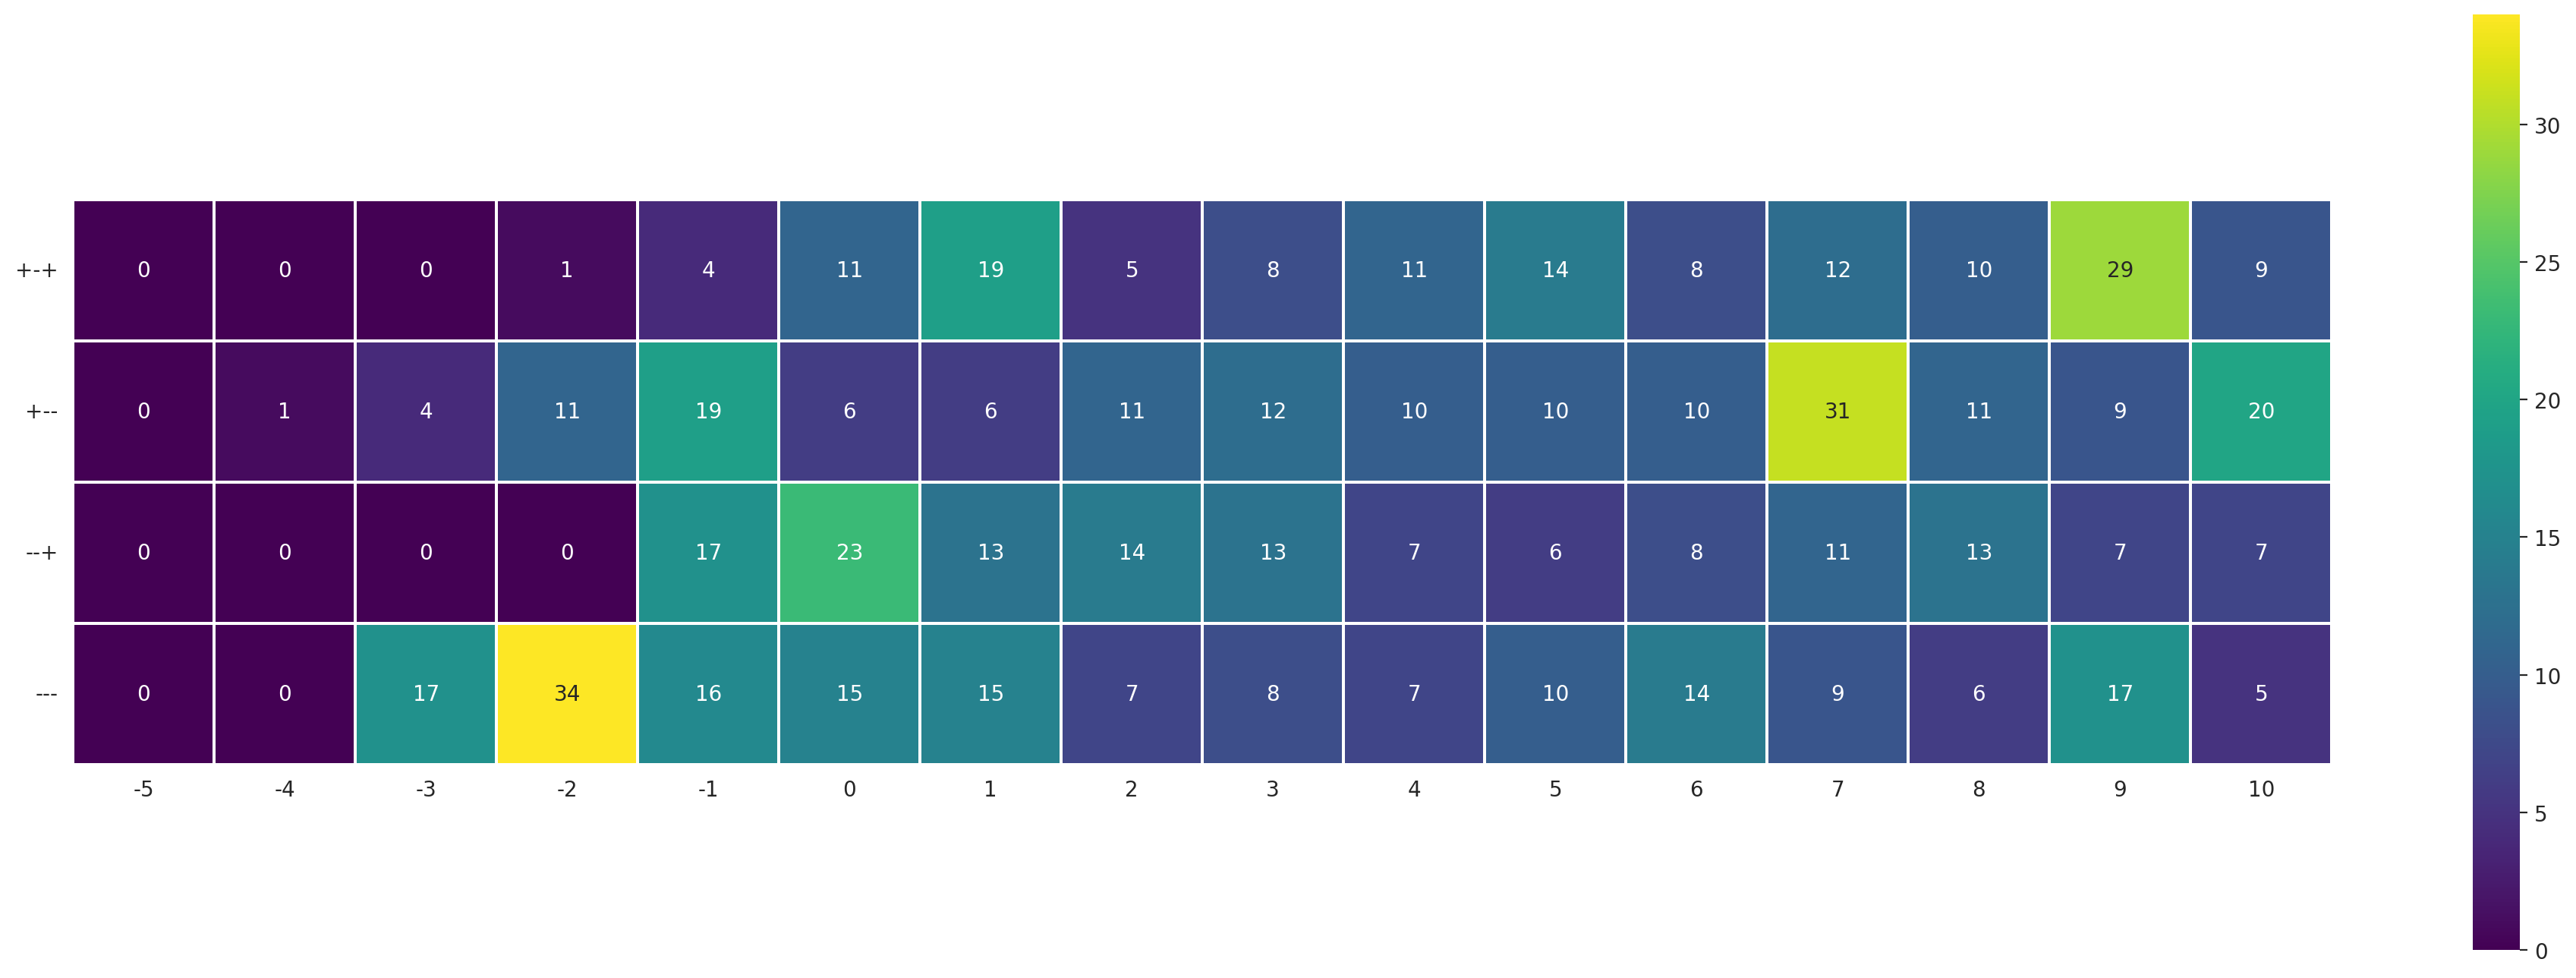

In [231]:
preferred_motif_set_name = ('XBP1','SOX5')
dict_temp =CESeek_obj.count_CE_configuration_for_motif_pair(*preferred_motif_set_name)
fig=plt.figure(figsize=(24,8) , 
#                dpi= 300, 
               facecolor='w', edgecolor='k')
# df_plot=pd.DataFrame(dict_temp[list(dict_temp.keys())[0]]).sort_index().T.applymap(lambda x: -np.log10(x))

df_plot=pd.DataFrame(dict_temp[list(dict_temp.keys())[0]]).sort_index().T

fig = sns.heatmap(df_plot, 
#                    center=0, 
#                    cmap="vlag",
                   cmap="viridis",
#                    vmin=-1,
                   annot=True,
                square=True,
                   linewidths=.75, )

fig.set(xlabel="", ylabel="")
# fig.xaxis.tick_top()
fig.tick_params(top=False)
plt.yticks(rotation=0) 

In [232]:
def calculate_ceseek(preferred_motif_set_name, p_value_threshold = None):
    # Calculating scores for the preferred motif set
    # preferred_motif_set_name=('Nfatc1(MA0624.3)', 'JUN(MA0488.2)')
    ce_seek_score =CESeek_obj.count_CE_configuration_for_motif_pair(*preferred_motif_set_name)
    ce_seek_score_df=pd.DataFrame(ce_seek_score[list(ce_seek_score.keys())[0]]).sort_index().T

    # Calculate the p-value for the preferred motif set
    dict_temp = OrderedDict({ preferred_motif_set_name: {(strand1, strand2): {} for strand1 in ["+", "-"] for strand2 in ["+", "-"]}})

    for strand1 in ["+", "-"]:
        for strand2 in ["+", "-"]:
            for spacing in range(-5,10+1):
                key = (strand1, strand2)
                p_value=CESeek_obj.double_motif_enrichment(*preferred_motif_set_name, strand1=strand1, strand2=strand2, spacing=spacing)
                dict_temp[preferred_motif_set_name][key][spacing] = p_value

    ce_seek_pval_df=pd.DataFrame(dict_temp[preferred_motif_set_name]).sort_index().T
    try:
        ## Finding top CE-Score satisfying the p-value threshold of 0.05 from ce_seek_pval_df, ce_seek_score_df
        if p_value_threshold is not None:
            # Filter p-values that satisfy the threshold
            filtered_pvals = ce_seek_pval_df[ce_seek_pval_df <= p_value_threshold]  
            # Find the corresponding scores for the filtered p-values
            filtered_scores = ce_seek_score_df.where(filtered_pvals.notna())
            if not filtered_scores.isna().all().all():  # Ensure there is at least one valid value
                max_score = filtered_scores.max().max()  # Get max score
                max_score_loc = filtered_scores.stack().idxmax()  # Get location of max score
                if max_score_loc in filtered_pvals.stack(): # Ensure max_score_loc exists in filtered_pvals before indexing
                    max_score_pval = filtered_pvals.stack()[max_score_loc]
                else:
                    max_score_pval = np.nan  # Handle missing values
            else:
                max_score = max_score_loc = max_score_pval = np.nan  # No valid scores found
        else:
            max_score = ce_seek_score_df.max().max()
            max_score_loc = ce_seek_score_df.stack().idxmax()
            max_score_pval = ce_seek_pval_df.stack().loc[max_score_loc]
    except Exception as e:
        print(f"Error processing combination {preferred_motif_set_name}: {e}")
    
    return max_score, max_score_loc, max_score_pval

In [235]:
from tqdm import tqdm
ce_seek_scores = pd.DataFrame(columns=["preferred_motif_set_name", "max_score", "max_score_loc", "max_score_pval"])
rows = []
for type in comb_of_interest.keys():
    for comb in tqdm(comb_of_interest[type]):
        if comb[0] in tf_of_interest and comb[1] in tf_of_interest:
            preferred_motif_set_name = comb
            max_score, max_score_loc, max_score_pval = calculate_ceseek(preferred_motif_set_name, 0.05)
            rows.append({"preferred_motif_set_name": preferred_motif_set_name, "max_score": max_score, "max_score_loc": max_score_loc, "max_score_pval": max_score_pval, "type": type})
ce_seek_scores = pd.concat([ce_seek_scores, pd.DataFrame(rows)], ignore_index=True)
ce_seek_scores.to_csv(f"{out_path}/out_files/ce_seek_scores.csv", index=False)

100%|██████████| 222/222 [00:03<00:00, 59.41it/s]


In [240]:
ce_seek_scores['log10_pval'] = -np.log10(ce_seek_scores['max_score_pval'])
ce_seek_scores['log10_score'] = np.log10(ce_seek_scores['max_score'])

/ocean/projects/cis240075p/skeshari/.conda/envs/ceseek_env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log10

/ocean/projects/cis240075p/skeshari/.conda/envs/ceseek_env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log10



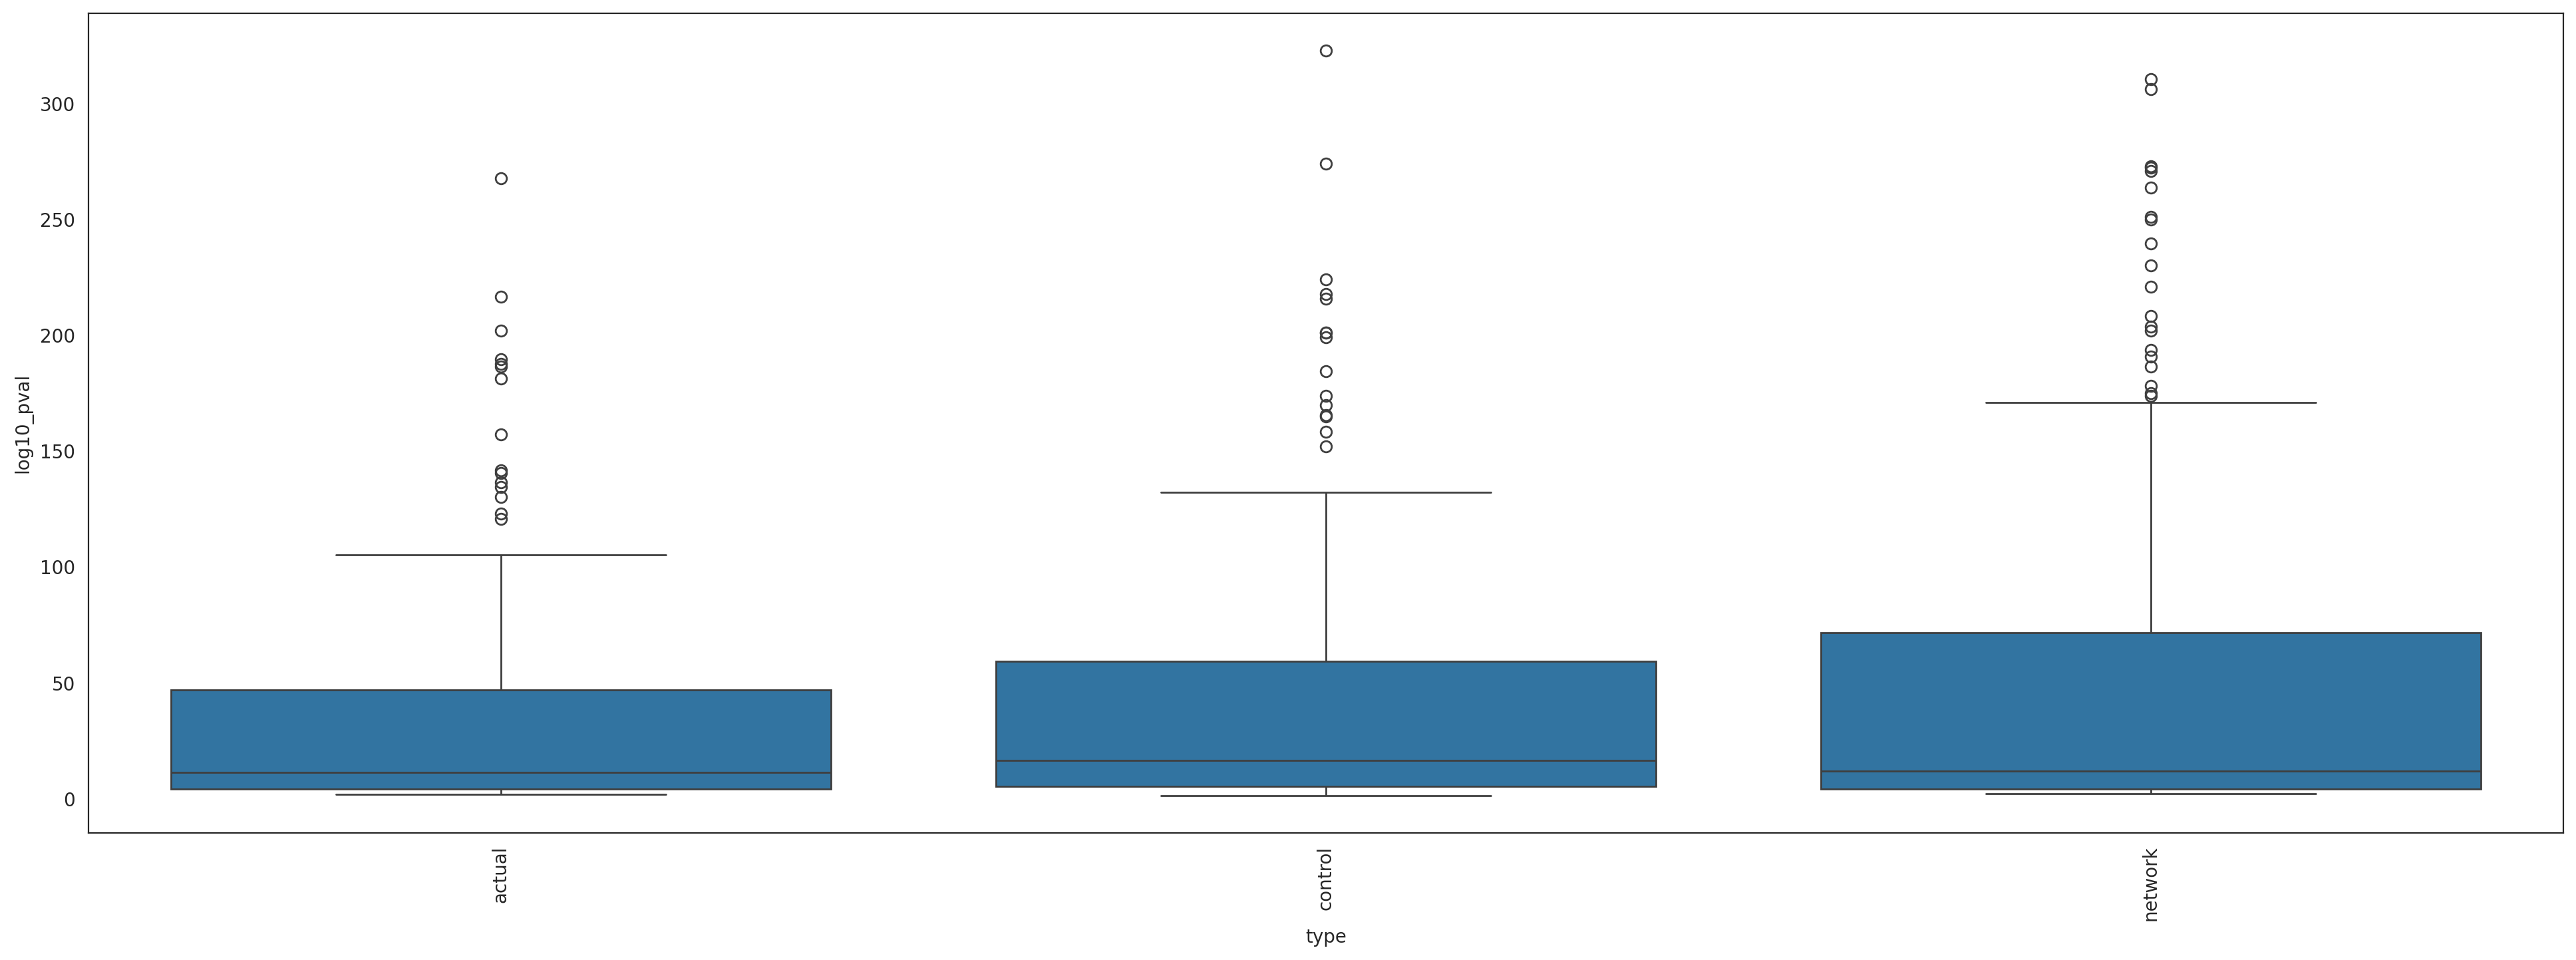

In [241]:
#plot scores
fig=plt.figure(figsize=(24,8), dpi= 300, facecolor='w', edgecolor='k')
sns.boxplot(data=ce_seek_scores, x='type', y='log10_pval')
plt.xticks(rotation=90)
plt.show()

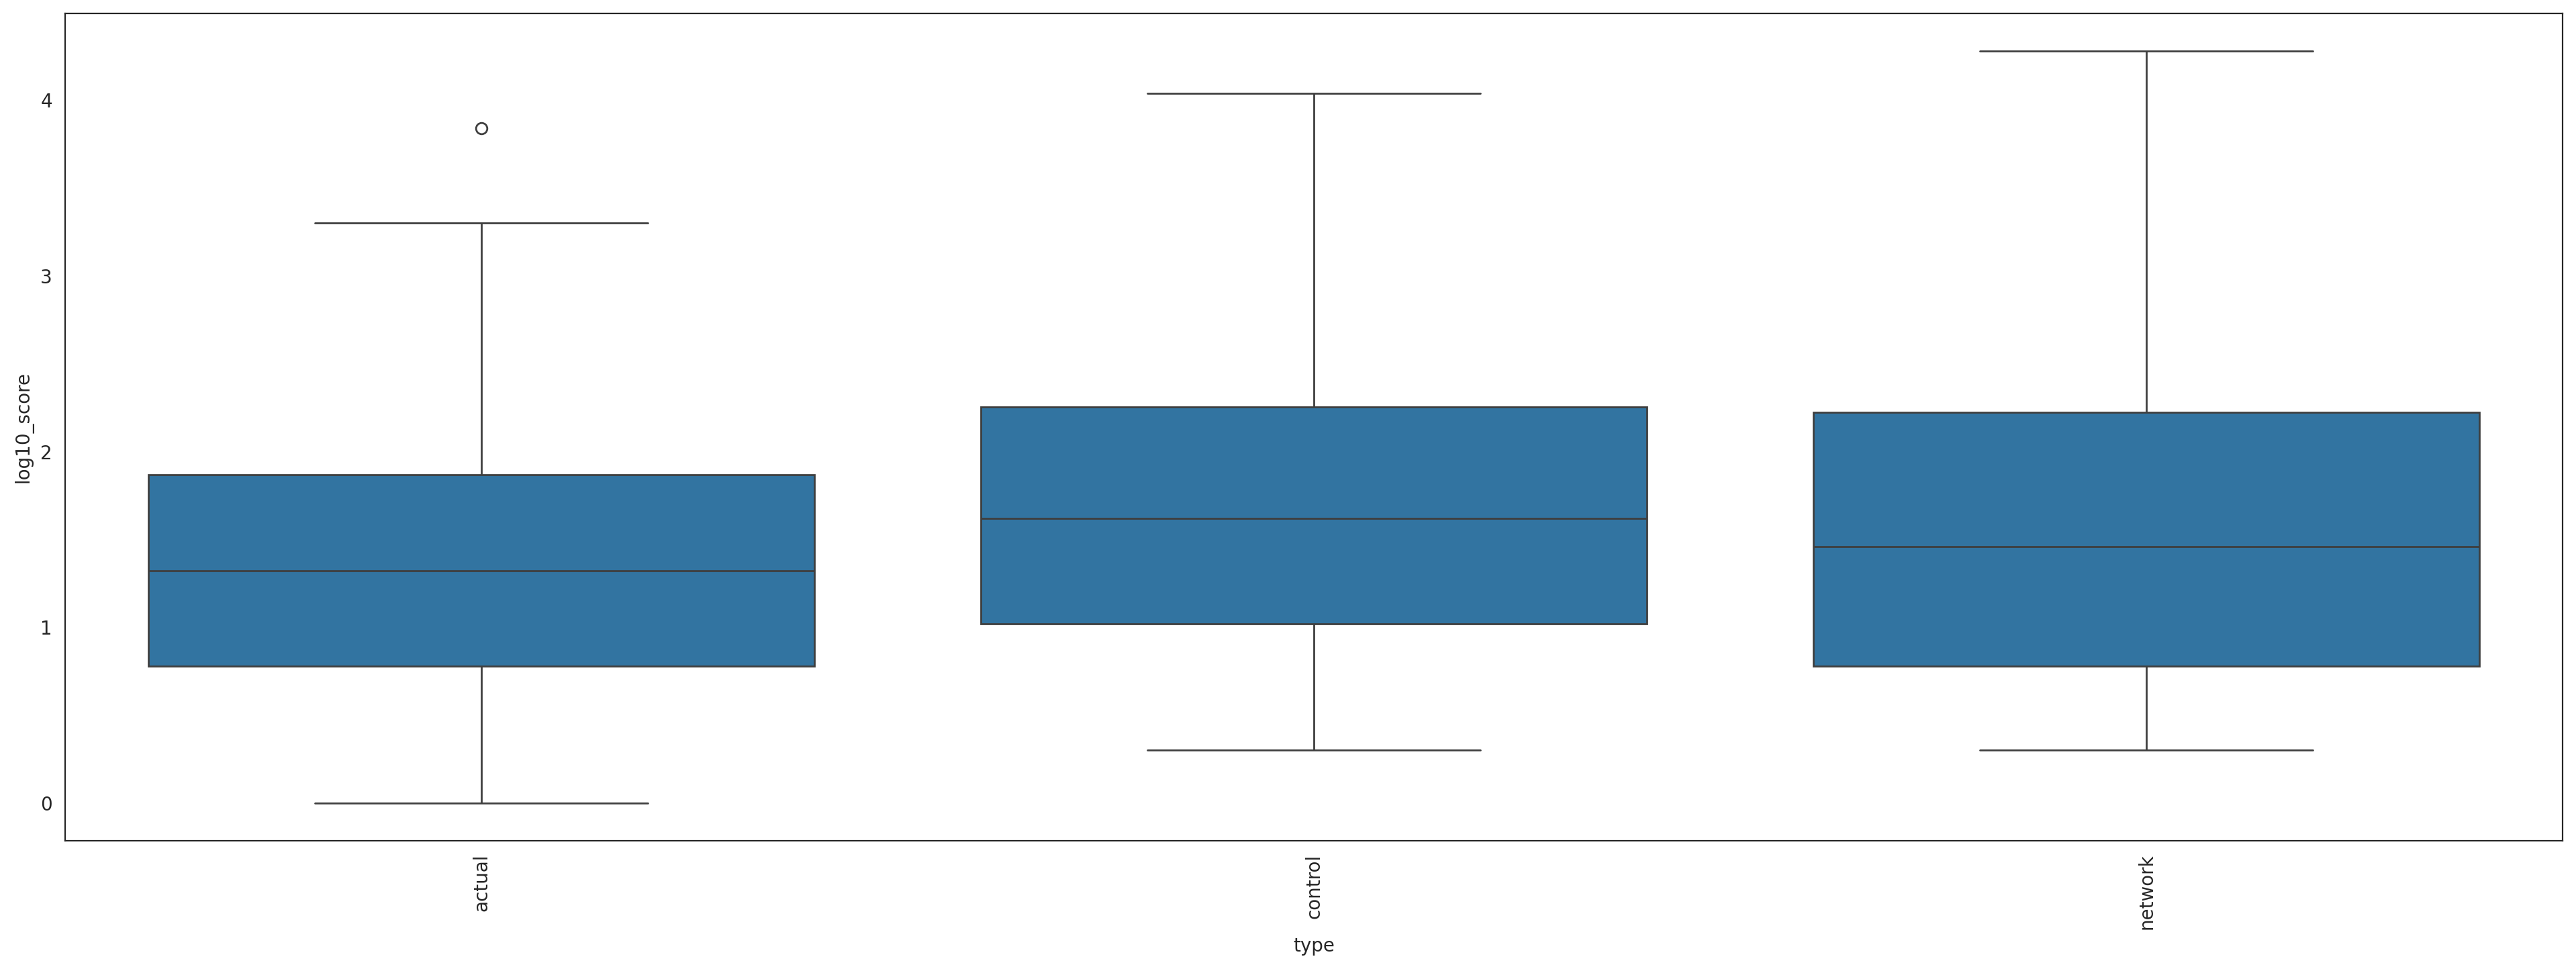

In [242]:
#plot scores
fig=plt.figure(figsize=(24,8), dpi= 300, facecolor='w', edgecolor='k')
sns.boxplot(data=ce_seek_scores, x='type', y='log10_score')
plt.xticks(rotation=90)
plt.show()

In [2]:
#### This is for creating one time objects for CESeek and Cicero

def create_CEseek_obj(wd, out_path):
    CEseek_obj = CEseek()
    CEseek_obj.load_sequences(f"{wd}/in_data_required/cell_ranger_output_aggr/atac_peaks.bed",
                             genome_sequence_fa="/ocean/projects/cis240075p/skeshari/utils_data/genomes/GRCh38.p14.genome.fa", 
                             fasta_input=False, out_seq_len=300)
    # Generate random control sequences in batches
    sequence_len = len(CEseek_obj.sequences)
    batch_size = int(1e5)
    random_sequences = []
    for _ in tqdm(range(0, sequence_len, batch_size), desc='Generating control sequences'):
        random_sequences.extend([get_random_seq(300) for _ in range(min(batch_size, 10 * sequence_len))])
    CEseek_obj.sequences_control = random_sequences
    with open(f'{out_path}/out_files/CEseek_obj_pre_motif_scan.pkl', 'wb') as f:
        pickle.dump(CEseek_obj, f)
    return CEseek_obj

def process_batch_for_cicero_peaks_indexed(batch):
    batch_dict = {}
    for _, row in batch.iterrows():
        key = sorted((row['Peak1_idx'], row['Peak2_idx']))
        if key[0] not in batch_dict:
            batch_dict[key[0]] = {}
        batch_dict[key[0]][key[1]] = row['coaccess']
    return batch_dict

def create_cicero_peaks_indexed(wd, out_path):
    # Build Cicero connections matrix
    cicero_conns = pd.read_csv(f"{wd}/out_data/cicero_output/cicero_connections.csv", header=0, index_col=0).dropna()
    cicero_conns = cicero_conns[cicero_conns['coaccess'] != 0].reset_index(drop=True)
    cicero_peaks_set = pd.concat([cicero_conns['Peak1'], cicero_conns['Peak2']]).unique() # Precompute indices for peaks
    cicero_peaks_index = {peak: idx for idx, peak in enumerate(sorted(cicero_peaks_set))}

    with open(f"{out_path}/out_files/cicero_peaks_indexed.pkl", 'wb') as f:
        pickle.dump(cicero_peaks_index, f)
    
    cicero_conns['Peak1_idx'] = cicero_conns['Peak1'].map(cicero_peaks_index)
    cicero_conns['Peak2_idx'] = cicero_conns['Peak2'].map(cicero_peaks_index)

    # Split into batches and save in compressed format
    index_value_dict = {}
    num_chunks = mp.cpu_count()
    chunks = np.array_split(cicero_conns, num_chunks)

    with mp.Pool(num_chunks) as pool:
        results = list(tqdm(pool.imap(process_batch_for_cicero_peaks_indexed, chunks), total=num_chunks, desc='Processing Cicero connections batches'))
    
    for result in results:
        index_value_dict.update(result)

    with open(f"{out_path}/out_files/matrix_index_value.pkl", 'wb') as f:
        pickle.dump(index_value_dict, f)
    return cicero_peaks_index, index_value_dict


In [2]:
#### This is for reading one time objects for CESeek and Cicero
run_CEseek, run_cicerocc = True, False
if run_CEseek:
    if not os.path.exists(f"{out_path}/out_files/CEseek_obj_pre_motif_scan.pkl"):
        CEseek_obj = create_CEseek_obj(wd, out_path)
    else:
        print(f"Loading CEseek object {out_path}/out_files/CEseek_obj_pre_motif_scan.pkl. Delete it if you want to re-create it.")
        with open(f"{out_path}/out_files/CEseek_obj_pre_motif_scan.pkl", 'rb') as f:
            CEseek_obj = pickle.load(f)

if run_cicerocc:
    if (not os.path.exists(f"{out_path}/out_files/cicero_peaks_indexed.pkl")) or (not os.path.exists(f"{out_path}/out_files/matrix_index_value.pkl")):
        cicero_peaks_index, index_value_dict = create_cicero_peaks_indexed(wd, out_path)
    else:
        print(f"Loading cicero peaks indexed {out_path}/out_files/cicero_peaks_indexed.pkl. Delete it if you want to re-create it.")
        with open(f"{out_path}/out_files/cicero_peaks_indexed.pkl", 'rb') as f:
            cicero_peaks_index = pickle.load(f)
        print(f"Loading cicero peaks indexed {out_path}/out_files/matrix_index_value.pkl. Delete it if you want to re-create it.")
        with open(f"{out_path}/out_files/matrix_index_value.pkl", 'rb') as f:
            index_value_dict = pickle.load(f)


Loading CEseek object /ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/out_data/ce_seek/out_files/CEseek_obj_pre_motif_scan.pkl. Delete it if you want to re-create it.
Loading cicero peaks indexed /ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/out_data/ce_seek/out_files/cicero_peaks_indexed.pkl. Delete it if you want to re-create it.
Loading cicero peaks indexed /ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/out_data/ce_seek/out_files/matrix_index_value.pkl. Delete it if you want to re-create it.


In [12]:
def get_binding_peaks_for_motif(motif):
    motif_df = pd.read_csv(f"{out_path}/out_files/txt_files_for_cicero/{motif}.txt", sep='\t', usecols=['chrom', 'start', 'end']).drop_duplicates()
    motif_df['concat'] = motif_df.apply(lambda row: f"{row['chrom']}_{row['start']}_{row['end']}", axis=1)
    motif_df['peak_index'] = motif_df['concat'].map(cicero_peaks_index)
    return motif_df['peak_index'].dropna().astype(int).values

def motif_peak_pair_intersection_cicero_connections(motif1_peak_idx_chunk):
    result_chunk = []
    for idx1 in motif1_peak_idx_chunk:
        for idx2 in motif2_peak_idx:
            try:
                key = sorted((idx1, idx2))
                result_chunk.append((idx1, idx2, index_value_dict[key[0]][key[1]]))
            except KeyError:
                pass
    return result_chunk

In [ ]:
corr_peak_for_motif_pair = []
for preferred_motif_set_name in tqdm(comb_of_interest[0:2], desc='Processing combinations for Cicero'):
    preferred_motif_set_name = ['RUNX2(MA0511.2)', 'IRF4(MA1419.2)']
    motif1_peak_idx = get_binding_peaks_for_motif(preferred_motif_set_name[0], cicero_peaks_index)
    motif2_peak_idx = get_binding_peaks_for_motif(preferred_motif_set_name[1], cicero_peaks_index)
    motif1_bag = db.from_sequence(motif1_peak_idx, partition_size=1000)
    motif2_bag = db.from_sequence(motif2_peak_idx, partition_size=1000)
    cartesian_product_bag = motif1_bag.product(motif2_bag)
    result_bag = cartesian_product_bag.map(lambda pair: motif_peak_pair_intersection_cicero_connections(pair[0], pair[1])).filter(lambda x: x[2] is not None)
    result_df = result_bag.compute()
    corr_peak_for_motif_pair.append((*preferred_motif_set_name, len(result_df), motif1_peak_idx.shape[0] * motif2_peak_idx.shape[0]))
    print(f"Done with {preferred_motif_set_name}")
    client.restart()

In [12]:
# client.restart()
# comb_of_interest_bag = db.from_sequence(comb_of_interest, partition_size=1)
preferred_motif_set_name = ['RUNX2(MA0511.2)', 'IRF4(MA1419.2)']
motif1_peak_idx = get_binding_peaks_for_motif(preferred_motif_set_name[0], cicero_peaks_index)
motif2_peak_idx = get_binding_peaks_for_motif(preferred_motif_set_name[1], cicero_peaks_index)
motif1_bag = db.from_sequence(motif1_peak_idx, partition_size=1000)
motif2_bag = db.from_sequence(motif2_peak_idx, partition_size=1000)
cartesian_product_bag = motif1_bag.product(motif2_bag)
result_bag = cartesian_product_bag.map(lambda pair: motif_peak_pair_intersection_cicero_connections(pair[0], pair[1])).filter(lambda x: x[2] is not None)
result_df = result_bag.compute()


/ocean/projects/cis240075p/skeshari/.conda/envs/ceseek_env/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning:

Sending large graph of size 53.22 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.



In [ ]:
def get_binding_peaks_for_motif_pair(motif_name1, motif_name2, cicero_peaks_index):
    motif_arrays = []
    for motif in [motif_name1, motif_name2]:
        motif_df = pd.read_csv(f"{out_path}/out_files/txt_files_for_cicero/{motif}.txt", sep='\t', header=0)[['chrom', 'start', 'end']].drop_duplicates().reset_index(drop=True)
        motif_df['concat'] = motif_df['chrom'].astype(str) + "_" + motif_df['start'].astype(str) + "_" + motif_df['end'].astype(str)
        motif_df['peak_index'] = motif_df['concat'].map(cicero_peaks_index)
        motif_df = motif_df.dropna()
        motif_arrays.append(np.array(motif_df['peak_index'].values, dtype=np.int32))
    return motif_arrays

def motif_peak_pair_intersection_cicero_connections(motif1_peak_idx_chunk, motif2_peak_idx):
    result_chunk = []

    for idx1 in motif1_peak_idx_chunk:
        for idx2 in motif2_peak_idx:
            try:
                key = sorted((idx1, idx2))
                result_chunk.append((key[0], key[1],index_value_dict[key[0]][key[1]]))
            except KeyError:
                pass
    return result_chunk

def process_comb_of_interest(preferred_motif_set_name):
    corr_peak_for_motif_pair = []
    batch_size = 10
    motif1_peak_idx, motif2_peak_idx = get_binding_peaks_for_motif_pair(*preferred_motif_set_name, cicero_peaks_index)
    chunks = np.array_split(motif1_peak_idx, len(motif1_peak_idx) // batch_size)
    results = []
    for chunk in tqdm(chunks, desc=f'Processing Cicero connections for motif pair {preferred_motif_set_name}'):
        results.append(motif_peak_pair_intersection_cicero_connections(chunk, motif2_peak_idx))
    result = [item for sublist in results for item in sublist]
    cnt_thr_pos_idx = len([x for x in result if abs(x[2]) >= 0.05])
    corr_peak_for_motif_pair.append((*preferred_motif_set_name, cnt_thr_pos_idx, motif1_peak_idx.shape[0] * motif2_peak_idx.shape[0]))
    return corr_peak_for_motif_pair

# Curating Cicero results
corr_peak_for_motif_pair = []
batch_size = 10
comb_of_interest_1 = comb_of_interest[1:6]
with mp.Pool(mp.cpu_count()) as pool:
    results = pool.map(process_comb_of_interest, comb_of_interest_1)

result = [item for sublist in results for item in sublist]


# for preferred_motif_set_name in comb_of_interest[1:2]:
#     motif1_peak_idx, motif2_peak_idx = get_binding_peaks_for_motif_pair(*preferred_motif_set_name, cicero_peaks_index)
#     chunks = np.array_split(motif1_peak_idx, len(motif1_peak_idx) // batch_size)
#     results = []
#     for chunk in tqdm(chunks, desc='Processing Cicero connections for motif pair'):
#         results.append(motif_peak_pair_intersection_cicero_connections(chunk))
#     result = [item for sublist in results for item in sublist]
#     cnt_thr_pos_idx = len([x for x in result if abs(x[2]) >= 0.05])
#     corr_peak_for_motif_pair.append((*preferred_motif_set_name, cnt_thr_pos_idx, motif1_peak_idx.shape[0] * motif2_peak_idx.shape[0]))


# Creating CEseek object with the atac peaks

In [3]:
CEseek_obj = CEseek()
wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/'
CEseek_obj.load_sequences(f"{wd}/in_data_required/cell_ranger_output_aggr/atac_peaks.bed",
                         genome_sequence_fa="/ocean/projects/cis240075p/skeshari/utils_data/genomes/GRCh38.p14.genome.fa", 
                         fasta_input=False, out_seq_len=300)
CEseek_obj.sequences_control=[get_random_seq(300) for _ in range(10*len(CEseek_obj.sequences))]
save_path = os.path.join(out_path, 'out_files/CEseek_obj_pre_motif_scan.pkl')
with open(save_path, 'wb') as f:
    pickle.dump(CEseek_obj, f)
print(f"CEseek_obj saved to {save_path}")

CEseek_obj saved to /ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/out_data/ce_seek/out_files/CEseek_obj_pre_motif_scan.pkl


# Creating Cicero index dictionary for atac

In [3]:
def build_cicero_conns_matrix(batch):
    idx0 = batch['Peak1_idx'].to_numpy(dtype=np.int64)
    idx1 = batch['Peak2_idx'].to_numpy(dtype=np.int64)
    values = batch['coaccess'].to_numpy(dtype=np.float16)

    mask = idx0 <= idx1
    upper_indices = np.stack([idx0[mask], idx1[mask]], axis=0)
    upper_values = values[mask]
    lower_indices = np.stack([idx1[~mask], idx0[~mask]], axis=0)
    lower_values = values[~mask]
    final_upper_indices = np.concatenate([upper_indices, lower_indices], axis=1)
    final_upper_values = np.concatenate([upper_values, lower_values])
    assert final_upper_indices[1].all() <= final_upper_values[0].all() , f"Assertion for upper indices failed"
    return final_upper_indices, final_upper_values

In [16]:
# Build Cicero connections matrix
cicero_conns = pd.read_csv(f"{wd}/out_data/cicero_output/cicero_connections.csv", header=0, index_col=0).dropna()
cicero_conns = cicero_conns[cicero_conns['coaccess'] != 0].reset_index(drop=True)
# Precompute indices
cicero_peaks_set = pd.concat([cicero_conns['Peak1'], cicero_conns['Peak2']]).unique()
cicero_peaks_index = {peak: idx for idx, peak in enumerate(sorted(cicero_peaks_set))}
with open(f"{out_path}/out_files/cicero_peaks_indexed.pkl", 'wb') as f:
    pickle.dump(cicero_peaks_index, f)

cicero_conns['Peak1_idx'] = cicero_conns['Peak1'].map(cicero_peaks_index)
cicero_conns['Peak2_idx'] = cicero_conns['Peak2'].map(cicero_peaks_index)
num_peaks = len(cicero_peaks_index)

available_memory = psutil.virtual_memory().available / (1024**3)
batch_size = int(1e6 if available_memory > 2 else 1e5)
batches = [cicero_conns.iloc[i:i + batch_size] for i in range(0, len(cicero_conns), batch_size)]
# Process batches
matrix = []
for batch in tqdm(batches, total=len(batches), desc='Building Cicero connections matrix'):
    matrix.append(build_cicero_conns_matrix(batch))
# Combine results
upper_indices, upper_values = matrix[0]
for mtx in matrix[1:]:
    upper_indices = np.concatenate([upper_indices, mtx[0]], axis=1)
    upper_values = np.concatenate([upper_values, mtx[1]])
index_value_dict = {(upper_indices[0, i], upper_indices[1, i]): upper_values[i] for i in range(upper_indices.shape[1])}
with open(f"{out_path}/out_files/matrix_index_value.pkl", 'wb') as f:
    pickle.dump(index_value_dict, f)
# del cicero_conns, matrix
# torch.cuda.empty_cache()


Building Cicero connections matrix: 100%|██████████| 9/9 [00:00<00:00, 46.31it/s]


In [3]:
def calculate_ceseek(preferred_motif_set_name):
    # Calculating scores for the preferred motif set
    # preferred_motif_set_name=('Nfatc1(MA0624.3)', 'JUN(MA0488.2)')
    ce_seek_score =CEseek_obj.count_CE_configuration_for_motif_pair(*preferred_motif_set_name)
    ce_seek_score_df=pd.DataFrame(ce_seek_score[list(ce_seek_score.keys())[0]]).sort_index().T

    # Calculate the p-value for the preferred motif set
    dict_temp = OrderedDict({
    preferred_motif_set_name: {(strand1, strand2): {} for strand1 in ["+", "-"] for strand2 in ["+", "-"]}
    })
    EPS = 1e-40
    for strand1 in ["+", "-"]:
        for strand2 in ["+", "-"]:
            for spacing in range(-5,10+1):
                key = (strand1, strand2)
                p_value=CEseek_obj.motif_enrichment(*preferred_motif_set_name, strand1=strand1, strand2=strand2, spacing=spacing)
                dict_temp[preferred_motif_set_name][key][spacing] = p_value

    ce_seek_pval_df=pd.DataFrame(dict_temp[preferred_motif_set_name]).sort_index().T
    max_score = ce_seek_score_df.max().max()
    max_score_loc = ce_seek_score_df.stack().idxmax()
    max_score_pval = ce_seek_pval_df.stack().loc[max_score_loc]

    # # Finding top CE-Score satisfying the p-value threshold of 0.05 from ce_seek_pval_df, ce_seek_score_df
    # p_value_threshold = 0.05 # Define the p-value threshold
    # log_p_value_threshold = -np.log10(p_value_threshold) # Convert the p-value threshold to -log10 scale
    # filtered_pvals = ce_seek_pval_df[ce_seek_pval_df >= log_p_value_threshold] # Filter the p-values that satisfy the threshol
    # filtered_scores = ce_seek_score_df[filtered_pvals.notna()] # Find the corresponding scores for the filtered p-values
    # try: 
    #     max_score = filtered_scores.max().max() # Find the maximum score and its location
    #     max_score_loc = filtered_scores.stack().idxmax()
    # except ValueError:
    #     max_score = 0
    #     max_score_loc = 0
    print(f"Preferred motif set: {preferred_motif_set_name} completed")
    return max_score, max_score_loc, max_score_pval

def safe_caclulate_ceseek(comb):
    try:
        return caclulate_ceseek(comb)
    except Exception as e:
        print(f"Error processing combination {comb}: {e}")
        return None, None


In [23]:
def get_binding_peaks_for_motif_pair(motif_name1, motif_name2):
    motif_arrays = []
    for motif in [motif_name1, motif_name2]:
        motif_df = pd.read_csv(f"{out_path}/out_files/txt_files_for_cicero/{motif}.txt", sep='\t', header=0)[['chrom', 'start', 'end']].drop_duplicates().reset_index(drop=True)
        motif_df['concat'] = motif_df['chrom'].astype(str) + "_" + motif_df['start'].astype(str) + "_" + motif_df['end'].astype(str)
        motif_df['peak_index'] = motif_df['concat'].map(cicero_peaks_index)
        motif_df = motif_df.dropna()
        motif_arrays.append(np.array(motif_df['peak_index'].values, dtype=np.int32))
    return motif_arrays

def motif_peak_pair_intersection_cicero_connections(motif1_peak_idx_chunk):
    result_chunk = []
    for idx1 in motif1_peak_idx_chunk:
        for idx2 in motif2_peak_idx:
            try:
                if idx1 <= idx2:
                    result_chunk.append((idx1, idx2, index_value_dict[(idx1, idx2)]))
                else:
                    result_chunk.append((idx2, idx1, index_value_dict[(idx2, idx1)]))
            except KeyError:
                pass
    return result_chunk

# MAIN FUNCTION BELOW

In [26]:
# Directory containing the text files with JASPAR motifs
cluster_pairs = [('GC-1','PB-2' ),('PB-2', 'ActB-2'),('GC-1','ActB-2')]
with open(f"{out_path}/out_files/CEseek_obj_pre_motif_scan.pkl", 'rb') as f:
    CEseek_obj = pickle.load(f)
with open(f"{out_path}/out_files/cicero_peaks_indexed.pkl", 'rb') as f:
    cicero_peaks_index = pickle.load(f)
with open(f"{out_path}/out_files/matrix_index_value.pkl", 'rb') as f:
    index_value_dict = pickle.load(f)

for cluster_pair in cluster_pairs[0:1]:
    CEseek_obj.read_motif_pwm((os.path.join(wd, 'out_data',f'comb_ctrl/out_files/concatenated_pwm_{cluster_pair}.txt')))
    CEseek_obj.scan_motifs(num_threads=os.cpu_count())
    # Writing motif search for cicero in txt files
    for TF in tqdm(CEseek_obj.dict_motif.keys()):
        if not os.path.exists(f"{out_path}/out_files/txt_files_for_cicero/{TF}.txt"):
            CEseek_obj.extract_CE_sequences(TF, None, None, None, None, outfile=f"{out_path}/out_files/txt_files_for_cicero/{TF}.txt")
    
    slide_enriched_tfs = pd.read_csv(f"{wd}/out_data/comb_ctrl/out_files/SLIDE_LF_enriched_double_TFs_{cluster_pair}.csv")
    shuffle_enriched_tfs = pd.read_csv(f"{wd}/out_data/comb_ctrl/out_files/shuffled_SLIDE_LF_enriched_double_TFs_{cluster_pair}.csv")
    network_score_tfs = pd.read_csv(f"{wd}/out_data/comb_ctrl/out_files/CO_network_score_double_TFs_{cluster_pair}.csv")
    random_tfs = pd.read_csv(f"{wd}/out_data/comb_ctrl/out_files/random_TFs_{cluster_pair}.csv")

    comb_of_interest = set(list(zip(slide_enriched_tfs['TF1'], slide_enriched_tfs['TF2'])) + \
                        list(zip(shuffle_enriched_tfs['TF1'], shuffle_enriched_tfs['TF2'])) + \
                        list(zip(network_score_tfs['TF1'], network_score_tfs['TF2'])) + \
                        list(zip(random_tfs['TF1'], random_tfs['TF2'])))

    # Curating CEseek results
    max_scores, max_score_locs = [],[]
    p_value_threshold = 0.05
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(safe_caclulate_ceseek, comb_of_interest), total=len(comb_of_interest), desc='Processing combinations for CEseek'))
    max_scores, max_score_locs = zip(*results)
    CEseek_results_df = pd.DataFrame({'Combination': comb_of_interest,'Max_Score': max_scores,'Location': max_score_locs})
    CEseek_results_df.to_csv(f"{out_path}/out_files/CEseek_results.csv", index=False)

    # Curating Cicero results
    corr_peak_for_motif_pair = []
    num_chunks = os.cpu_count()
    for preferred_motif_set_name in tqdm(comb_of_interest[0:1], desc='Processing combinations for Cicero'):
        motif1_peak_idx, motif2_peak_idx = get_binding_peaks_for_motif_pair(*preferred_motif_set_name)
        union_peak_index = set(np.concatenate([motif1_peak_idx, motif2_peak_idx]))
        logging.info(f"STEP3: Binding peaks for motifs {preferred_motif_set_name} have been loaded")
        chunks = np.array_split(motif1_peak_idx, num_chunks)
        with mp.Pool(num_chunks) as pool:
            results = pool.map(motif_peak_pair_intersection_cicero_connections, chunks)
        logging.info(f"STEP4: Pair of peaks found in cicero connections has been counted for {preferred_motif_set_name}")
        result = [item for sublist in results for item in sublist]
        cnt_thr_pos_idx = len([x for x in result if abs(x[2]) >= 0.05]) 
        jaccard_index = cnt_thr_pos_idx / len(union_peak_index)
        corr_peak_for_motif_pair.append((*preferred_motif_set_name, cnt_thr_pos_idx, len(union_peak_index), jaccard_index))

    # Save the results
    cicero_results_df = pd.DataFrame(corr_peak_for_motif_pair, columns=['TF1', 'TF2', 'cnt_thr_pos_idx', 'union_peak_index', 'jaccard_index'])
    cicero_results_df.to_csv(f"{out_path}/out_files/cicero_correlation_results.csv", index=False)
    logging.info("Results have been saved")



Processing combinations for Cicero:   0%|          | 0/1 [00:00<?, ?it/s]INFO:root:STEP3: Binding peaks for motifs ('BACH2(MA1470.2)', 'EBF1(MA0154.5)') have been loaded
INFO:root:STEP4: Pair of peaks found in cicero connections has been counted for ('BACH2(MA1470.2)', 'EBF1(MA0154.5)')
Processing combinations for Cicero: 100%|██████████| 1/1 [00:08<00:00,  8.28s/it]
INFO:root:Results have been saved


# Plotting Code

In [70]:
cluster_pairs = [('GC-1','PB-2' ),('PB-2', 'ActB-2'),('GC-1','ActB-2')]
cluster_pair = cluster_pairs[0]
slide_enriched_tfs_scores = pd.read_csv(f"{wd}/out_data/comb_ctrl/out_files/SLIDE_LF_enriched_double_TFs_{cluster_pair}.csv").set_index(['TF1', 'TF2'])['Score'].to_dict()
ceseek_scores = pd.read_csv(f"{out_path}/out_files/CEseek_results.csv").set_index(['Combination'])
ceseek_scores = ceseek_scores['Max_Score'][ceseek_scores['P-value'] < 0.1].to_dict()
ceseek_scores = {eval(k): v for k, v in ceseek_scores.items()}
cicero_correlation_scores = pd.read_csv(f"{out_path}/out_files/cicero_correlation_results.csv")
cicero_correlation_scores ['ratio'] = cicero_correlation_scores['cnt_thr_pos_idx'] / cicero_correlation_scores['possibilities']
cicero_correlation_scores = cicero_correlation_scores.set_index(['TF1', 'TF2'])['ratio'].to_dict()

In [71]:
shuffle_enriched_tfs = pd.read_csv(f"{wd}/out_data/comb_ctrl/out_files/shuffled_SLIDE_LF_enriched_double_TFs_{cluster_pair}.csv")
network_score_tfs = pd.read_csv(f"{wd}/out_data/comb_ctrl/out_files/CO_network_score_double_TFs_{cluster_pair}.csv")
random_tfs = pd.read_csv(f"{wd}/out_data/comb_ctrl/out_files/random_double_TFs_{cluster_pair}.csv")

actual_pairs = list(slide_enriched_tfs_scores.keys())
shuffle_enriched_tfs_pairs = list(zip(shuffle_enriched_tfs['TF1'], shuffle_enriched_tfs['TF2']))
network_score_tfs_pairs = list(zip(network_score_tfs['TF1'], network_score_tfs['TF2']))
random_tfs_pairs = list(zip(random_tfs['TF1'], random_tfs['TF2']))

In [76]:
def get_binding_peaks_for_motif(motif):
    motif_df = pd.read_csv(f"{out_path}/out_files/txt_files_for_cicero/{motif}.txt", sep='\t', usecols=['chrom', 'start', 'end']).drop_duplicates()
    motif_df['concat'] = motif_df.apply(lambda row: f"{row['chrom']}:{row['start']}-{row['end']}", axis=1)
    return motif_df
def rp_scores_for_motif_pair(preferred_motif_set_name): 
    scores = []
    motif1_peak_idx = get_binding_peaks_for_motif(preferred_motif_set_name[0])
    motif2_peak_idx = get_binding_peaks_for_motif(preferred_motif_set_name[1])
    motif1_scores = rp_scores[rp_scores['gene_ids'].isin(motif1_peak_idx['concat'])].sort_values('rp_peak_score', ascending=False).drop_duplicates('gene_ids')['rp_peak_score'].values
    motif2_scores = rp_scores[rp_scores['gene_ids'].isin(motif2_peak_idx['concat'])].sort_values('rp_peak_score', ascending=False).drop_duplicates('gene_ids')['rp_peak_score'].values
    scores.extend(motif1_scores)
    scores.extend(motif2_scores)
    return np.mean(scores)
def calculate_scores(pairs, ceseek_scores, cicero_correlation_scores):
    ceseek_scores_list = []
    cicero_correlation_scores_list = []
    rp_peak_scores_list = []
    for pair in pairs:
        if pair in ceseek_scores:
            ceseek_score = ceseek_scores[pair]
            ceseek_scores_list.append(ceseek_score)
        else:
            ceseek_scores_list.append(None)
        
        if pair in cicero_correlation_scores:
            cicero_correlation_score = cicero_correlation_scores[pair]
            cicero_correlation_scores_list.append(cicero_correlation_score)
        else:
            cicero_correlation_scores_list.append(None)
    try:
        with mp.Pool(10) as pool:
            rp_peak_scores_list = pool.map(rp_scores_for_motif_pair, pairs)
    except Exception as e:
        print(e)
        rp_peak_scores_list.append(None)
  
    return pd.DataFrame({
        'Pair': pairs,
        'CEseek_Score': ceseek_scores_list,
        'Cicero_Correlation_Score': cicero_correlation_scores_list,
        'RP_Peak_Score': rp_peak_scores_list
    })

# Calculate results for each set of pairs
results_df = calculate_scores(actual_pairs, ceseek_scores, cicero_correlation_scores)
shuffle_results_df = calculate_scores(shuffle_enriched_tfs_pairs, ceseek_scores, cicero_correlation_scores)
network_results_df = calculate_scores(network_score_tfs_pairs, ceseek_scores, cicero_correlation_scores)
random_results_df = calculate_scores(random_tfs_pairs, ceseek_scores, cicero_correlation_scores)
print(len(results_df), len(shuffle_results_df), len(network_results_df), len(random_results_df))

103 103 103 103


In [77]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_all_in_one(results_df, shuffle_results_df, network_results_df, random_results_df):
    fig = make_subplots(rows=1, cols=3, subplot_titles=("CEseek_Score", "Cicero_Correlation_Score", "RP_Peak_Score"))

    # Add traces for results_df
    fig.add_trace(go.Box(y=np.log10(results_df['CEseek_Score'].dropna() + 1), name=f'Actual (n={results_df["CEseek_Score"].dropna().shape[0]})', boxmean=True, marker_color='blue'), row=1, col=1)
    fig.add_trace(go.Box(y=np.log10(shuffle_results_df['CEseek_Score'].dropna() + 1), name=f'Shuffle (n={shuffle_results_df["CEseek_Score"].dropna().shape[0]})', boxmean=True, marker_color='orange'), row=1, col=1)
    fig.add_trace(go.Box(y=np.log10(network_results_df['CEseek_Score'].dropna() + 1), name=f'Network (n={network_results_df["CEseek_Score"].dropna().shape[0]})', boxmean=True, marker_color='green'), row=1, col=1)
    fig.add_trace(go.Box(y=np.log10(random_results_df['CEseek_Score'].dropna() + 1), name=f'Random (n={random_results_df["CEseek_Score"].dropna().shape[0]})', boxmean=True, marker_color='red'), row=1, col=1)

    fig.add_trace(go.Box(y=results_df['Cicero_Correlation_Score'].dropna(), name=f'Actual (n={results_df["Cicero_Correlation_Score"].dropna().shape[0]})', boxmean=True, marker_color='blue'), row=1, col=2)
    fig.add_trace(go.Box(y=shuffle_results_df['Cicero_Correlation_Score'].dropna(), name=f'Shuffle (n={shuffle_results_df["Cicero_Correlation_Score"].dropna().shape[0]})', boxmean=True, marker_color='orange'), row=1, col=2)
    fig.add_trace(go.Box(y=network_results_df['Cicero_Correlation_Score'].dropna(), name=f'Network (n={network_results_df["Cicero_Correlation_Score"].dropna().shape[0]})', boxmean=True, marker_color='green'), row=1, col=2)
    fig.add_trace(go.Box(y=random_results_df['Cicero_Correlation_Score'].dropna(), name=f'Random (n={random_results_df["Cicero_Correlation_Score"].dropna().shape[0]})', boxmean=True, marker_color='red'), row=1, col=2)

    fig.add_trace(go.Box(y=results_df['RP_Peak_Score'].dropna(), name=f'Actual (n={results_df["RP_Peak_Score"].dropna().shape[0]})', boxmean=True, marker_color='blue'), row=1, col=3)
    fig.add_trace(go.Box(y=shuffle_results_df['RP_Peak_Score'].dropna(), name=f'Shuffle (n={shuffle_results_df["RP_Peak_Score"].dropna().shape[0]})', boxmean=True, marker_color='orange'), row=1, col=3)
    fig.add_trace(go.Box(y=network_results_df['RP_Peak_Score'].dropna(), name=f'Network (n={network_results_df["RP_Peak_Score"].dropna().shape[0]})', boxmean=True, marker_color='green'), row=1, col=3)
    fig.add_trace(go.Box(y=random_results_df['RP_Peak_Score'].dropna(), name=f'Random (n={random_results_df["RP_Peak_Score"].dropna().shape[0]})', boxmean=True, marker_color='red'), row=1, col=3)

    fig.update_layout(height=600, width=1800, title_text="CEseek and Cicero Correlation Scores")
    fig.show()
    fig.write_html(f"{out_path}/figures/CEseek_Cicero_Scores.html")

plot_all_in_one(results_df, shuffle_results_df, network_results_df, random_results_df)